<a href="https://colab.research.google.com/github/NRafif/Machine-Learning/blob/main/MobileNetV2_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LIBRARY

In [1]:
from google.colab import files    # Untuk upload files
import zipfile                    # Untuk unzip file
import os                         # Untuk interaksi dengan os
import matplotlib.pyplot as plt   # Untuk visualisasi data
import matplotlib.image as mpimg  # Membaca dan memanipulasi gambar
from google.colab import drive    # Untuk mengakses google drive
import tensorflow as tf           # Library utama untuk Machine learning
import numpy as np                # Library untuk komputasi numerik
from PIL import Image
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import model_from_json

import json
import itertools

In [2]:
# This should show version 2.2 to match the autograder
print('\u2022 Using TensorFlow Version:', tf.__version__)

• Using TensorFlow Version: 2.17.1


In [3]:
pip show keras

Name: keras
Version: 3.5.0
Summary: Multi-backend Keras.
Home-page: https://github.com/keras-team/keras
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache License 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, packaging, rich
Required-by: tensorflow


In [4]:
batch_size = 32
img_height = 224
img_width = 224

# PERSIAPAN DATASET


Mengambil dataset dari kaggle

In [5]:
!pip install -q Kaggle

In [6]:
uploaded = files.upload()

In [7]:
!mkdir -p ~/.kaggle                #membuat folder .kaggle di root
!mv kaggle.json ~/.kaggle/         #memindahkan file kaggle.json ke folder ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json   #merubah permission file kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [8]:
!kaggle datasets download -d adityavahreza/cat-skin-disease

Dataset URL: https://www.kaggle.com/datasets/adityavahreza/cat-skin-disease
License(s): unknown
 43% 17.0M/39.6M [00:00<00:00, 63.6MB/s]
100% 39.6M/39.6M [00:00<00:00, 110MB/s] 


Load Dataset


In [9]:
# Extract zipfile
! unzip "/content/cat-skin-disease.zip" -d.

Archive:  /content/cat-skin-disease.zip
  inflating: ./CAT SKIN DISEASE/Flea_Allergy/1000010593_x4.jpg  
  inflating: ./CAT SKIN DISEASE/Flea_Allergy/1000010601_x4.jpg  
  inflating: ./CAT SKIN DISEASE/Flea_Allergy/1000010627_x4.jpg  
  inflating: ./CAT SKIN DISEASE/Flea_Allergy/1000010771_x16.jpg  
  inflating: ./CAT SKIN DISEASE/Flea_Allergy/340947808_546167834308890_7592465449990658927_n.jpg  
  inflating: ./CAT SKIN DISEASE/Flea_Allergy/5d5641b96b930df01eb7df119e680c9fdb41f4e4_jpeg.jpg  
  inflating: ./CAT SKIN DISEASE/Flea_Allergy/Atopic-dermatitis_Red-skin-dog-abdomen_DermVets.jpg  
  inflating: ./CAT SKIN DISEASE/Flea_Allergy/Image_1-4-.jpg  
  inflating: ./CAT SKIN DISEASE/Flea_Allergy/Image_12-2-.jpg  
  inflating: ./CAT SKIN DISEASE/Flea_Allergy/Image_13.jpg  
  inflating: ./CAT SKIN DISEASE/Flea_Allergy/Image_14 (2).jpg  
  inflating: ./CAT SKIN DISEASE/Flea_Allergy/Image_14-2-.jpg  
  inflating: ./CAT SKIN DISEASE/Flea_Allergy/Image_15-2-.jpg  
  inflating: ./CAT SKIN DISEA

Menentukan class

In [10]:
cat_disease = "/content/CAT SKIN DISEASE"
cat_disease_classes = os.listdir(cat_disease)

In [11]:
print("Cat Skin Disease Class :")
for class_name in cat_disease_classes:
  if os.path.isdir(os.path.join(cat_disease, class_name)):
    print(class_name)

Cat Skin Disease Class :
Health
Scabies
Flea_Allergy
Ringworm


Preview Gambar


Health
Total Image :  111
Resolusi Gambar :  (640, 640, 3)


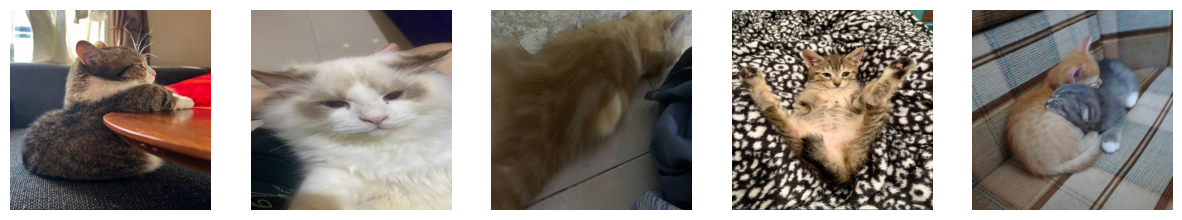


Scabies
Total Image :  150
Resolusi Gambar :  (481, 291, 4)


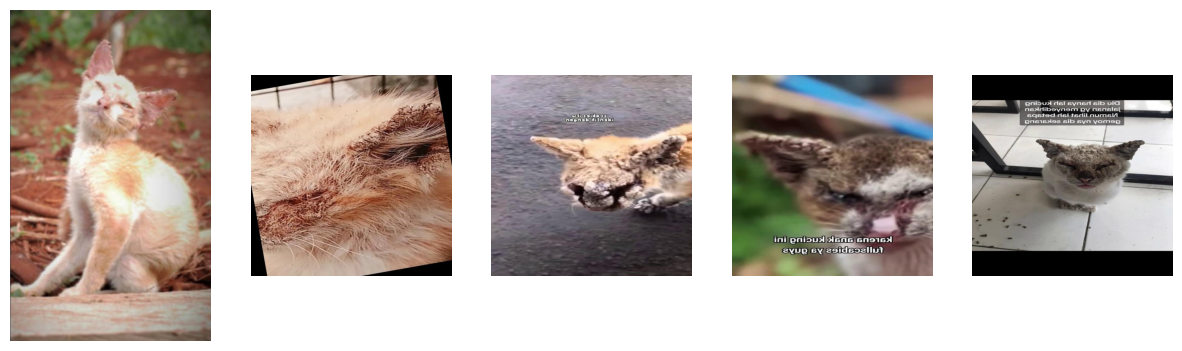


Flea_Allergy
Total Image :  142
Resolusi Gambar :  (343, 774, 3)


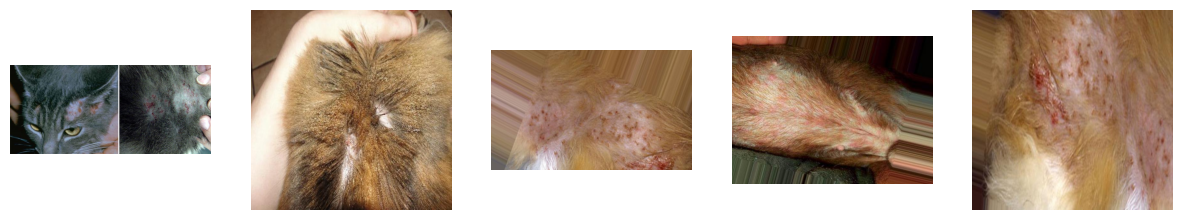


Ringworm
Total Image :  147
Resolusi Gambar :  (640, 640, 3)


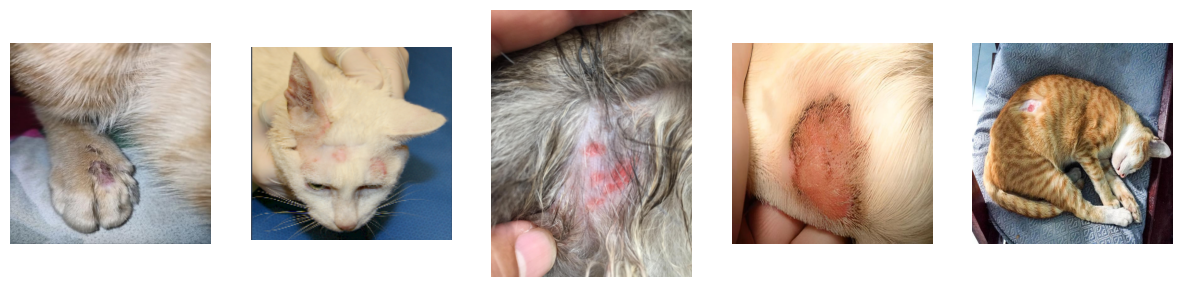

In [12]:
for item in cat_disease_classes:
    print("")
    print(item)
    class_dir = os.path.join(cat_disease, item)
    class_images = [img for img in os.listdir(class_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

    # Menghitung total image di setiap kelas
    num_images = len(class_images)
    print("Total Image : ", num_images)

    # Menghitung resolusi pada gambar pertama
    img_path = os.path.join(class_dir, class_images[0])
    img = mpimg.imread(img_path)
    image_shape = img.shape
    print("Resolusi Gambar : ", image_shape)

    # Menampilkan beberapa gambar
    plt.figure(figsize=(15, 5))
    for i in range(min(5, len(class_images))):  # Tampilkan maksimum 5 gambar atau sesuai jumlah yang tersedia
        sp = plt.subplot(1, 5, i + 1)
        img = mpimg.imread(os.path.join(class_dir, class_images[i]))
        plt.axis('off')
        plt.imshow(img)
    plt.show()


# PREPOCESING DATA


Split data

In [13]:
def train_val_Dataset():
  training_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(
      cat_disease,
      image_size=(img_height, img_width),
      color_mode='rgb',
      batch_size= batch_size,
      label_mode='categorical',
      validation_split=0.2,
      subset='both',
      seed=42
  )

  return training_dataset, validation_dataset

In [14]:
# Membuat dataset
training_dataset, validation_dataset = train_val_Dataset()

Found 550 files belonging to 4 classes.
Using 440 files for training.
Using 110 files for validation.


In [15]:
# Melihat batch pertama dari image dan labels
for image_batch, labels_batch in training_dataset.take(1):
  example_batch = image_batch
  labels_batch = labels_batch

  print(f"maximum pixel value of images : {np.max(example_batch)}.\n")
  print(f"Image batch shape: {image_batch.shape}")
  print(f"Labels batch shape: {labels_batch.shape}")

maximum pixel value of images : 255.0.

Image batch shape: (32, 224, 224, 3)
Labels batch shape: (32, 4)


Augmentation

In [16]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomBrightness(0.3),
    tf.keras.layers.RandomTranslation(0.2, 0.2),
])

# Tambahkan augmentasi ke dataset
def apply_augmentation(training_dataset, validation_dataset):
    augmented_training_dataset = training_dataset.map(
        lambda x, y: (data_augmentation(x, training=True), y)
    )
    # Dataset validasi biasanya tidak memerlukan augmentasi
    return augmented_training_dataset, validation_dataset

# Panggil fungsi
training_dataset, validation_dataset = train_val_Dataset()
augmented_training_dataset, validation_dataset = apply_augmentation(training_dataset, validation_dataset)

Found 550 files belonging to 4 classes.
Using 440 files for training.
Using 110 files for validation.


# MODELING

In [17]:
base_model = MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights="imagenet"
    )

for layer in base_model.layers:
    layer.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(img_height, img_width, 3)),
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,917,956 (11.13 MB)

 Trainable params: 658,948 (2.51 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

In [20]:
model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
      loss="categorical_crossentropy",
      metrics=["accuracy"]
)

Buat fungsi callback

In [21]:
class early_stopping_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if logs.get('accuracy')>=0.85 and logs.get('val_accuracy')>=0.85:
      print("\nReached 85% train accuracy and 85% accuracy so cancelling training!")
      self.model.stop_training = True

Mulai train model

In [22]:
history = model.fit(
    augmented_training_dataset,
    validation_data=validation_dataset,
    epochs=25,
    callbacks=[early_stopping_callback()]
)

Epoch 1/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.2526 - loss: 2.1514 - val_accuracy: 0.4818 - val_loss: 1.1264
Epoch 2/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 625ms/step - accuracy: 0.4756 - loss: 1.3600 - val_accuracy: 0.6182 - val_loss: 0.9078
Epoch 3/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 570ms/step - accuracy: 0.5941 - loss: 1.1212 - val_accuracy: 0.6727 - val_loss: 0.7936
Epoch 4/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 628ms/step - accuracy: 0.6518 - loss: 1.0003 - val_accuracy: 0.7273 - val_loss: 0.7330
Epoch 5/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 686ms/step - accuracy: 0.6852 - loss: 0.7960 - val_accuracy: 0.7455 - val_loss: 0.6660
Epoch 6/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 555ms/step - accuracy: 0.6995 - loss: 0.8078 - val_accuracy: 0.7455 - val_loss: 0.6525
Epoch 7/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 558ms/step - accuracy: 0.7531 - loss: 0.7559 - val_accuracy: 0.7455 - val_loss: 0.6435
Epoch 8/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 580ms/step - accuracy: 0.7301 - loss: 0.7262 - val_accuracy: 

# Hasil Model

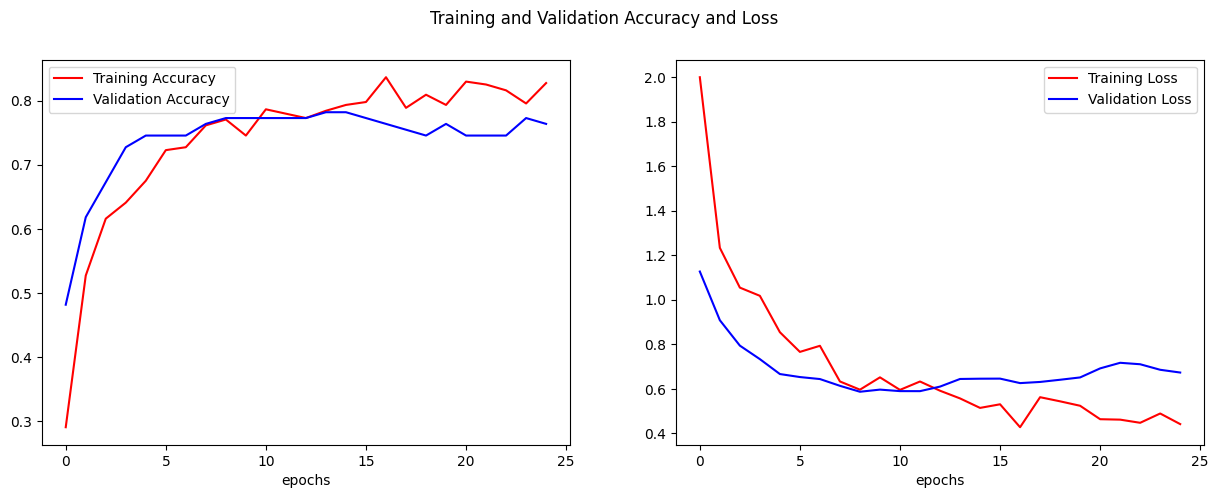

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Training and Validation Accuracy and Loss')

# Define data and labels for each subplot
data_labels = [
    (acc, val_acc, 'Accuracy'),
    (loss, val_loss, 'Loss')
]

# Iterate through subplots and data
for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    axs[i].plot(epochs_range, data[0], 'r', label="Training " + label)
    axs[i].plot(epochs_range, data[1], 'b', label="Validation " + label)
    axs[i].legend()
    axs[i].set_xlabel('epochs')

plt.show()

Saving 4_png.rf.9442139a99556d7588bc51fc86a82209.jpg to 4_png.rf.9442139a99556d7588bc51fc86a82209.jpg
User uploaded file "4_png.rf.9442139a99556d7588bc51fc86a82209.jpg" with length 23365 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: Flea_Allergy
Prediction probabilities: [[0.09476324 0.42708904 0.47725344 0.00089432]]


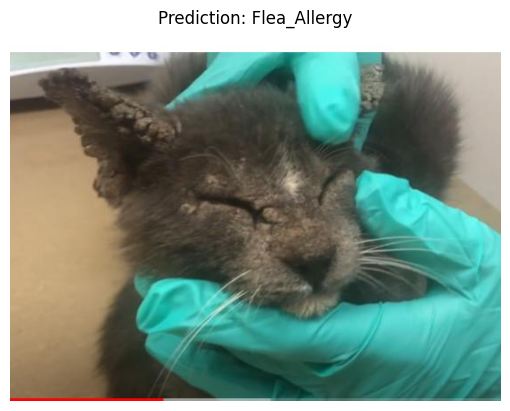

In [24]:
def predict_image(image_path, model):
    img = Image.open(image_path)
    img = img.resize((img_height, img_width))  # Resize image

    # Convert image to RGB format
    img = img.convert('RGB')  # This line is added to convert the image to RGB

    img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    # Memprediksi kelas yang
    predicted_class_name = cat_disease_classes[predicted_class]

    return predicted_class_name, prediction


# Upload file
uploaded = files.upload()

# Informasi file yang diupload
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Membuat prediksi
image_path = fn # Menggunakan nama file yang diupload
predicted_class_name, prediction = predict_image(image_path, model) # Gunakan model yang telah dilatih

print(f"Predicted class: {predicted_class_name}")
print(f"Prediction probabilities: {prediction}")

# Display the uploaded image
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {predicted_class_name}")
plt.show()

Saving 6_png.rf.9fa51ee79e9e7957c9a7c8154b1fec19.jpg to 6_png.rf.9fa51ee79e9e7957c9a7c8154b1fec19.jpg
User uploaded file "6_png.rf.9fa51ee79e9e7957c9a7c8154b1fec19.jpg" with length 37962 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted class: Flea_Allergy
Prediction probabilities: [[0.09335177 0.42298225 0.48277253 0.00089346]]


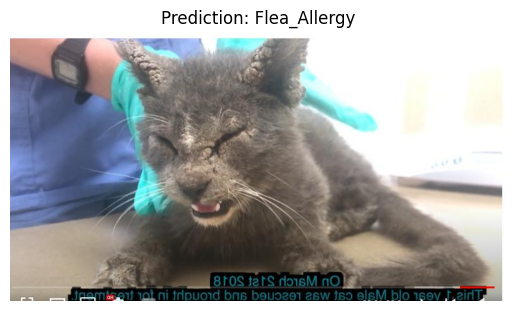

In [25]:
def predict_image(image_path, model):
    img = Image.open(image_path)
    img = img.resize((img_height, img_width))  # Resize image

    # Convert image to RGB format
    img = img.convert('RGB')  # This line is added to convert the image to RGB

    img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    # Memprediksi kelas yang
    predicted_class_name = cat_disease_classes[predicted_class]

    return predicted_class_name, prediction


# Upload file
uploaded = files.upload()

# Informasi file yang diupload
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Membuat prediksi
image_path = fn # Menggunakan nama file yang diupload
predicted_class_name, prediction = predict_image(image_path, model) # Gunakan model yang telah dilatih

print(f"Predicted class: {predicted_class_name}")
print(f"Prediction probabilities: {prediction}")

# Display the uploaded image
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {predicted_class_name}")
plt.show()

# SAVE MODEL

In [26]:
with open('label.txt', 'w') as f:
  for class_name in cat_disease_classes:
    f.write(f"{class_name}\n")

In [27]:
CATS_SKIN_DISEASE_MODEL = "exp_saved_model"

In [28]:
tf.saved_model.save(model, CATS_SKIN_DISEASE_MODEL)

In [29]:
%%bash -s $CATS_SKIN_DISEASE_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['inputs'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_inputs:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['output_0'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 4)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


2024-11-30 09:14:33.052558: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-30 09:14:33.070011: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-30 09:14:33.075477: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 09:14:34.206405: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0000 00:00:1732958075.613211    3233 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/b

In [31]:
loaded = tf.saved_model.load(CATS_SKIN_DISEASE_MODEL)

In [32]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'inputs': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs')})
{'output_0': TensorSpec(shape=(None, 4), dtype=tf.float32, name='output_0')}


In [33]:
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_SKIN_DISEASE_MODEL)

In [34]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [35]:
def representative_data_gen():
    for input_value, _ in test_batches.take(100):
        yield [input_value]

In [36]:
converter.representative_dataset = representative_data_gen

In [37]:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

In [4]:
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

NameError: name 'converter' is not defined

In [ ]:
# saved_model_path = "./my_model.h5"

# # YOUR CODE HERE
# model.save(saved_model_path)

In [ ]:
# import h5py

# # Coba buka file .h5
# file_path = "/content/my_model.h5"  # Ganti dengan nama file Anda
# try:
#     with h5py.File(file_path, "r") as f:
#         print("Isi file:")
#         print(list(f.keys()))
#         if 'model_weights' in f:
#             print("File hanya berisi bobot model.")
#         elif 'model_config' in f:
#             print("File berisi model lengkap.")
#         else:
#             print("Struktur file tidak dikenal.")
# except Exception as e:
#     print(f"Terjadi error saat membuka file: {e}")

In [2]:
# # Konvert model ke TF Lite
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Simpan model dalam format TF Lite
# with open('model.tflite', 'wb') as f:
#     f.write(tflite_model)